In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
#Data Preprocessing
base_skin_dir = os.path.join("E:\\study\\semester_3\\AI\\Project\\Dataset\\Images")
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
                       'nv': 'Melanocytic nevi',
                       'mel': 'Melanoma',
                       'bkl': 'Benign keratosis-like lesions ',
                       'bcc': 'Basal cell carcinoma',
                       'akiec': 'Actinic keratoses',
                       'vasc': 'Vascular lesions',
                       'df': 'Dermatofibroma'
                    }

In [3]:
# Reading CSV
cancer_dataset = pd.read_csv("E:\\study\\semester_3\\AI\\Project\\Dataset\\HAM10000_metadata.csv")
cancer_dataset['path'] = cancer_dataset['image_id'].map(imageid_path_dict.get)
cancer_dataset['cell_type'] = cancer_dataset['dx'].map(lesion_type_dict.get)
cancer_dataset['cell_type_idx'] = pd.Categorical(cancer_dataset['cell_type']).codes

In [4]:
cancer_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2


In [5]:
cancer_dataset['age'].fillna((cancer_dataset['age'].mean()), inplace=True)

C:\Users\Al forsan\AppData\Local\Temp\ipykernel_14192\2717525439.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cancer_dataset['age'].fillna((cancer_dataset['age'].mean()), inplace=True)


In [6]:
cancer_dataset = cancer_dataset[cancer_dataset['path'].notna()]
cancer_dataset['age'] = cancer_dataset['age'].fillna(cancer_dataset['age'].mean())
cancer_dataset['image'] = cancer_dataset['path'].map(lambda x: np.asarray(Image.open(x).resize((64, 64))) if x and os.path.exists(x) else None)


In [7]:
cancer_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,E:\study\semester_3\AI\Project\Dataset\Images\...,Benign keratosis-like lesions,2,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


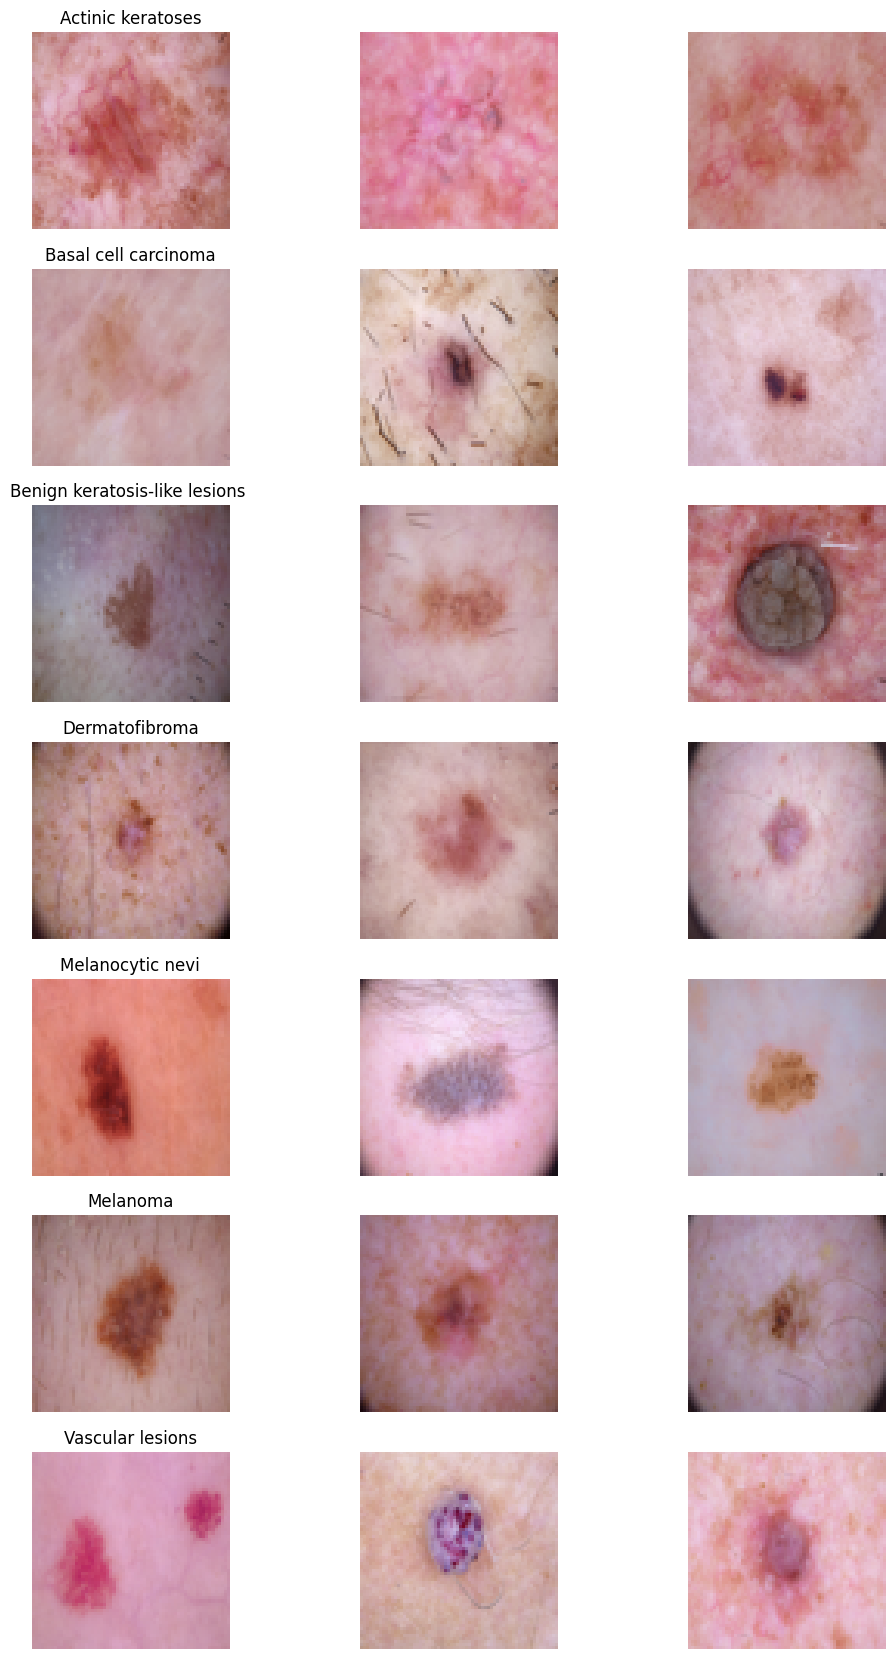

In [8]:
# Displaying samples
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         cancer_dataset.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [9]:
cancer_dataset['image'].map(lambda x: x.shape).value_counts()

image
(64, 64, 3)    10015
Name: count, dtype: int64

In [10]:
features = cancer_dataset.drop(columns=['cell_type_idx'], axis = 1)
target = cancer_dataset['cell_type_idx']

In [11]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.20, random_state=13269) 

In [12]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [13]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [14]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2) 

In [15]:
x_train = x_train.reshape(x_train.shape[0], *(64, 64, 3))
x_test = x_test.reshape(x_test.shape[0], *(64, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(64, 64, 3))

In [16]:
input_shape = (64, 64, 3)
num_classes = 7
classifier = Sequential()
classifier.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
classifier.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size = (2, 2)))
classifier.add(Dropout(0.15))

classifier.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
classifier.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
classifier.add(MaxPool2D(pool_size=(2, 2)))
classifier.add(Dropout(0.20))

classifier.add(Flatten())
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(num_classes, activation='softmax'))
classifier.summary()

c:\Users\Al forsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,909,799 (7.29 MB)

 Trainable params: 1,909,799 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
classifier.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
datagen = ImageDataGenerator(
                                featurewise_center = False, 
                                samplewise_center = False,  
                                featurewise_std_normalization = False, 
                                samplewise_std_normalization = False, 
                                zca_whitening = False, 
                                rotation_range = 90, 
                                zoom_range = 0.1,  
                                width_shift_range = 0.1, 
                                height_shift_range = 0.1,
                                horizontal_flip = True,  
                                vertical_flip = True
                            )

datagen.fit(x_train)

In [19]:
epochs = 150
batch_size = 10

history = classifier.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_validate, y_validate),
    steps_per_epoch=400
)

c:\Users\Al forsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.6338 - loss: 1.2294 - val_accuracy: 0.6521 - val_loss: 1.0283
Epoch 2/150
321/400 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6630 - loss: 0.9925

c:\Users\Al forsan\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6635 - loss: 0.9880 - val_accuracy: 0.6521 - val_loss: 0.9777
Epoch 3/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.6553 - loss: 0.9827 - val_accuracy: 0.6534 - val_loss: 0.9259
Epoch 4/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6686 - loss: 0.9419 - val_accuracy: 0.6584 - val_loss: 0.9713
Epoch 5/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.6832 - loss: 0.8969 - val_accuracy: 0.6721 - val_loss: 0.8589
Epoch 6/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6677 - loss: 0.9376 - val_accuracy: 0.6696 - val_loss: 0.8861
Epoch 7/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6934 - loss: 0.8498 - val_accuracy: 0.6733 - val_loss: 0.8647
Epoch 8/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.6863 - loss: 0.8559 - val_accuracy: 0.6596 - val_loss: 0.9062
Epoch 9/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6963 - loss: 0.8518 - val_

In [20]:
loss, accuracy = classifier.evaluate(x_test, y_test)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
classifier.save("my_model.keras")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7581 - loss: 0.6588
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7139 - loss: 0.7448
Validation: accuracy = 0.726933  ;  loss_v = 0.728906
Test: accuracy = 0.760359  ;  loss = 0.656543


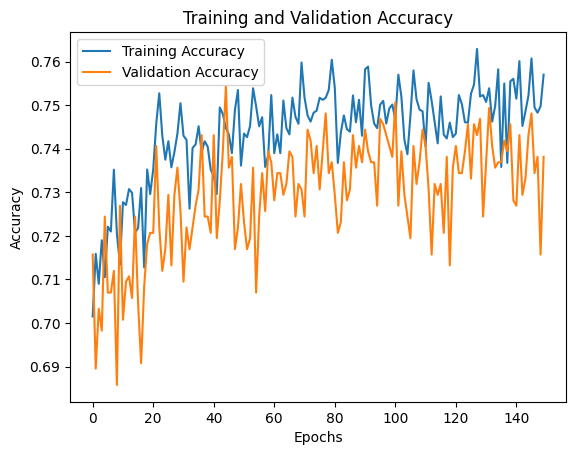

In [34]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()